In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

import torch
from torch import FloatTensor
from torch.autograd import Variable
from torch.nn import functional as F, Linear

In [2]:
#
# Helper functions
#

def inner_prod(x, y):
    """Compute the inner products between rows in x and y."""
    return (x * y).sum(1)


def cosine_sim(x, y):
    """Compute the cosine similarity between row of x and y."""
    Z = x.norm(dim=1) * y.norm(dim=1)
    return inner_prod(x, y) / Z


def all_same_size(seq):
    """Check that all elements of seq have the same size."""
    if len(seq) < 1:
        return True
    size = seq[0].size()
    for x in seq:
        if x.size() != size:
            return False
    return True

In [3]:
#
# Attention
#

def weighted_sum(weights, values):
    """Compute the sum of weights[i] * values[i].

    Expands weights[i] to match values[i].
    
    Arguments:
        weights (iterable): an iterable of Variables with size (1, 1), (m, 1), or (m, n).
        values (itearable): an iterable of Variables with size (m, n).
    
    Returns:
        weighted_sum (Variable): a Variable with shape (m, n).

    Raises:
        RuntimeError: if
            - len(weights) != len(values)
            - len(weights) == len(values) == 0
            - weights[i].size != weights[j].size for all i,j
            - values[i].size != values[j].size for all i,j
    """
    if len(weights) != len(values):
        raise RuntimeError('len(weights) = {} != {} = len(values)'.format(len(weights), len(values)))
    if len(weights) == 0:
        raise RuntimeError('cannot computed weighted sum of empty sequences')
    if not all_same_size(weights):
        raise RuntimeError('all weights do not have the same size')
    if not all_same_size(values):
        raise RuntimeError('all values do not have the same size')
    
    return sum(w.expand_as(v) * v for w, v in zip(weights, values))


def attend(query, keys, values=None, score=inner_prod):
    """Apply softmax attention over keys.

    Arguments:
        query (Variable): the query to compare to each key.
        keys (iterable): an iterable of Variables to compare to query.
        values (iterable): if given returns the weighted sum of probs[i] * values[i].
        score (function): the function used to compare each (key, query) pair.

    Returns:
        probs if values is None, otherwise the weighted sum of probs[i] * values[i].
    
    Raises:
        RuntimeError if len(keys) < 1
        See weighted_sum for other potential errors.
    """
    n_keys = len(keys)
    if n_keys < 1:
        raise RuntimeError('cannot compute attention over empty sequence')
    
    scores = [score(key, query) for key in keys]
    probs = F.softmax(torch.cat(scores, 1)).chunk(n_keys, 1)
    
    if values is None:
        return probs
    return weighted_sum(probs, values)

In [4]:
#
# Unit tests
#

def test():
    import unittest
    
    def FloatVar(x):
        return Variable(FloatTensor(x))

    class AttentionTest(unittest.TestCase):
        n_mem = 3
        v_dim = 4
        k_dim = 5
        batch_size = 2

        Q = [[ 5,  4, -1,  2],
             [ 5,  4,  2,  1]]

        V = [[[ 5, -5, -1, -2],
              [ 1,  0,  5,  0],
              [ 1, -3, -4,  1]],
             [[-1,  3,  5,  0],
              [-1, -4,  4,  1],
              [ 0,  0, -1,  4]]]

        K = [[[ 5,  2, -1,  0, -5],
              [ 1,  4, -1, -5, -5],
              [-4, -5,  0, -3,  3]],
             [[ 3,  5,  1, -3, -3],
              [-4, -2,  4,  3, -5],
              [ 2, -4, -1,  0,  4]]]

        p_q0_V0 = [0.8437947344813395, 0.11419519938459449, 0.04201006613406605]
        sum_p_q0_V0_V0 = [4.375178937925358, -4.345003870808895, -0.44085900209463125, -1.6455794028286128]
        sum_p_q0_V0_K0 = [4.165128607255028, 1.9343199358307268, -0.9579899338659339, -0.6970061953251705, -4.663919470927472]

        p_q1_V0 = [8.315280276639204e-07, 0.9999991684717178, 2.543663532246996e-13]
        sum_p_q1_V0_V0 = [1.0000033261121106, -4.157640901418662e-06, 4.999995010829543, -1.6630558009614876e-06]
        sum_p_q1_V0_K0 = [1.0000033261108388, 3.9999983369416547, -0.9999999999997454, -4.999995842359351, -4.999999999997963]

        p_q1_V1 = [0.9999996940975185, 2.5436648692632894e-13, 3.0590222692554685e-07]
        sum_p_q1_V1_V1 = [-0.9999996940977729, 2.9999990822915383, 4.999998164586383, 1.2236091620686743e-06]
        sum_p_q1_V1_K1 = [2.999999694095992, 4.999997246878176, 0.9999993881963092, -2.999999082291793, -2.99999785868492]
        
        def test_1xn_1xn(self):
            q = FloatVar([self.Q[0]])
            vs = [FloatVar([v]) for v in self.V[0]]
            ks = [FloatVar([k]) for k in self.K[0]]
            
            p = np.hstack(p.data.numpy() for p in attend(q, vs))
            self.assertEqual(p.shape, (1, self.n_mem))
            self.assertTrue(np.allclose(p, np.array([self.p_q0_V0])))

            h = attend(q, vs, vs).data.numpy()
            self.assertEqual(h.shape, (1, self.v_dim))
            self.assertTrue(np.allclose(h, np.array([self.sum_p_q0_V0_V0])))

            g = attend(q, vs, ks).data.numpy()
            self.assertEqual(g.shape, (1, self.k_dim))
            self.assertTrue(np.allclose(g, np.array([self.sum_p_q0_V0_K0])))
            
        def test_mxn_1xn(self):
            q = FloatVar(self.Q)
            vs = [FloatVar([v]).expand(self.batch_size, self.v_dim) for v in self.V[0]]
            ks = [FloatVar([k]).expand(self.batch_size, self.k_dim) for k in self.K[0]]
            
            p = np.hstack(p.data.numpy() for p in attend(q, vs))
            self.assertEqual(p.shape, (self.batch_size, self.n_mem))
            self.assertTrue(np.allclose(p, np.array([self.p_q0_V0, self.p_q1_V0])))

            h = attend(q, vs, vs).data.numpy()
            self.assertEqual(h.shape, (self.batch_size, self.v_dim))
            self.assertTrue(np.allclose(h, np.array([self.sum_p_q0_V0_V0, self.sum_p_q1_V0_V0])))

            g = attend(q, vs, ks).data.numpy()
            self.assertEqual(g.shape, (self.batch_size, self.k_dim))
            self.assertTrue(np.allclose(g, np.array([self.sum_p_q0_V0_K0, self.sum_p_q1_V0_K0])))

        def test_mxn_mxn(self):
            q = FloatVar(self.Q)
            vs = [FloatVar(v) for v in zip(*self.V)]
            ks = [FloatVar(k) for k in zip(*self.K)]
            
            p = np.hstack(p.data.numpy() for p in attend(q, vs))
            self.assertEqual(p.shape, (self.batch_size, self.n_mem))
            self.assertTrue(np.allclose(p, np.array([self.p_q0_V0, self.p_q1_V1])))

            h = attend(q, vs, vs).data.numpy()
            self.assertEqual(h.shape, (self.batch_size, self.v_dim))
            self.assertTrue(np.allclose(h, np.array([self.sum_p_q0_V0_V0, self.sum_p_q1_V1_V1])))

            g = attend(q, vs, ks).data.numpy()
            self.assertEqual(g.shape, (self.batch_size, self.k_dim))
            self.assertTrue(np.allclose(g, np.array([self.sum_p_q0_V0_K0, self.sum_p_q1_V1_K1])))

        def test_things_that_should_fail(self):
            with self.assertRaises(RuntimeError):
                # ks is empty
                q = FloatVar(self.Q)
                attend(q, [])

            with self.assertRaises(RuntimeError):
                # vs is empty
                q = FloatVar(self.Q)
                ks = [FloatVar(np.random.random((self.batch_size, self.k_dim))) for i in range(2)]
                attend(q, ks, [])

            with self.assertRaises(RuntimeError):
                # len(ks) != len(vs)
                q = FloatVar(self.Q)
                ks = [FloatVar(np.random.random((self.batch_size, self.k_dim))) for i in range(2)]
                vs = [FloatVar(np.random.random((self.batch_size, self.v_dim)))]
                attend(q, ks, vs)

            with self.assertRaises(RuntimeError):
                # ks[i] has wrong batch_size
                q = FloatVar(self.Q)
                ks = [FloatVar(np.random.random((1, self.k_dim))) for i in range(2)]
                attend(q, ks)

            with self.assertRaises(RuntimeError):
                # ks[i] has wrong batch_size
                q = FloatVar(self.Q)
                ks = [FloatVar(np.random.random((self.batch_size + 1, self.k_dim))) for i in range(2)]
                attend(q, ks)

            with self.assertRaises(RuntimeError):
                # vs[i] has wrong batch_size
                q = FloatVar(self.Q)
                ks = [FloatVar(np.random.random((self.batch_size, self.k_dim))) for i in range(2)]
                vs = [FloatVar(np.random.random((self.batch_size + 1, self.v_dim))) for i in range(2)]
                attend(q, ks, vs)

    unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(AttentionTest))
    print()

In [5]:
test()

....


----------------------------------------------------------------------
Ran 4 tests in 0.007s

OK


# Demo

For demonstration purposes the below code trains a simple [pointer network](https://arxiv.org/abs/1506.03134) like architecture to point to the position of the minimum or maximum element in a sequence of vectors along a particular coordinate. In other words, we'll have a neural network version of argmax/argmin.

### Setup

Let $x = (\mathbf{x}_1, \ldots, \mathbf{x}_T)$ be a sequence of $T$ vectors with each $\mathbf{x}_i \in \mathbb{R}^n$. The minimum and maximum target positions, $z_\min$ and $z_\max$, for the sequence are given by

$$
\begin{align*}
    t_\min &= \text{argmin}_t \left\{ x_{t,k_\min}\right\} \\
    t_\max &= \text{argmax}_t \left\{ x_{t,k_\max}\right\} \\
\end{align*}
$$

where $1 \leq k_\min \neq k_\max \leq p$ are a priori chosen coordiantes along which to compute the minimum or maximum.

### Model

Our model has the following form

$$
\begin{align*}
    \mathbf{h}_t &= W\mathbf{x}_t & \; t = 1, \ldots, T \\
    \mathbf{g} &= U\mathbf{q} \\
    \mathbf{p} &= \text{softmax}_t(\mathbf{g}^T \mathbf{h}_t)
\end{align*}
$$

where $W, U \in \mathbb{R}^{d \times n}$ and $\mathbf{q} \in \{\mathbf{q}_\min, \mathbf{q}_\max\} \subseteq \mathbb{R}^n$ are randomly chosen query vectors indicating whether the model should compute the minimum or maximum.

To demonstrate the usage of the `attend` function's `values` parameter the loss will be defined to be the mean squared error between the vector at the target position and the sum of the input vectors weighted by the degree to which they are attended to, i.e.,

$$
\begin{align*}
    \mathbf{y} &= \sum_t p_t \mathbf{x}_t \\
    l &= \frac{1}{n}\sum_i (y_i - x_{\tau,i})^2
\end{align*}
$$

where $\tau$ is either $t_\min$ or $t_\max$, which similary to $\mathbf{q}$ is dependent on which function the network meant to compute.

In [6]:
#
# Create training data
#


min_dim, max_dim = 3, 7
input_dim = 10
samples_per_length = 10
lengths = [5, 10, 15, 20]
q_min = np.random.normal(0, 1, input_dim).tolist()
q_max = np.random.normal(0, 1, input_dim).tolist()

mini_batches = []
for length in lengths:
    sequences = [[] for i in range(length)]
    queries = []
    targets = []
    for i in range(samples_per_length):
        seq = np.random.normal(0, 1, (length, input_dim)).tolist()
        min_target = min(seq, key=lambda x: x[min_dim])
        max_target = max(seq, key=lambda x: x[max_dim])
        for t, x in enumerate(seq):
            sequences[t].extend([x, x])
        queries.extend([q_min, q_max])
        targets.extend([min_target, max_target])

    sequences = [Variable(FloatTensor(x)) for x in sequences]
    queries = Variable(FloatTensor(queries))
    targets = Variable(FloatTensor(targets))
    mini_batches.append((sequences, queries, targets))

In [7]:
#
# Train
# 

embed_dim = 5
w = Linear(input_dim, embed_dim)
u = Linear(input_dim, embed_dim)
params = list(w.parameters()) + list(u.parameters())
opt = torch.optim.SGD(params, lr=0.01)
loss = torch.nn.MSELoss()

epoch = 0
prev_err = float('inf')
patience = 100
frustration = 0
tolerance = 1e-5
loss_values = []
while True:
    epoch += 1
    sum_err = 0.0
    random.shuffle(mini_batches)
    for xs, q, y in mini_batches:
        opt.zero_grad()
        p = attend(u(q), [w(x) for x in xs], xs)
        err = loss(p, y)
        err.backward()
        opt.step()
        sum_err += err.data.numpy()[0]
    err = sum_err / len(mini_batches)
    loss_values.append(err)
#     if epoch % 50 == 0:
#         print('epoch[{}] err = {}'.format(epoch, err))
    if err < prev_err - tolerance:
        frustration = 0
    else:
        frustration += 1
    if frustration > patience:
        break
    prev_err = err

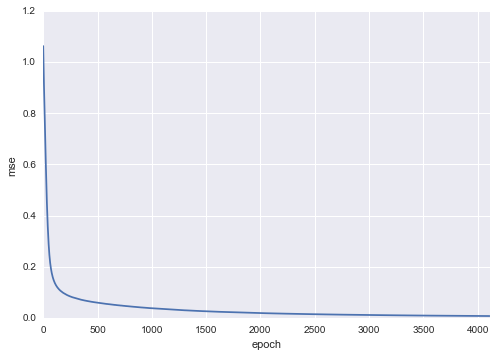

In [8]:
plt.plot(loss_values)
plt.xlim(0, len(loss_values))
plt.xlabel('epoch')
plt.ylabel('mse')

In [9]:
#
# Test
#


n_test = 10
errors_min = 0
errors_max = 0
length = 50

min_data, max_data = [], []

for i in range(n_test):
    seq = np.random.normal(0, 1, (length, input_dim)).tolist()
    
    min_values = [x[min_dim] for x in seq]
    min_sort = np.argsort([-x for x in min_values])
    min_index = min_sort[-1]
    
    max_values = [x[max_dim] for x in seq]
    max_sort = np.argsort(max_values)
    max_index = max_sort[-1]

    xs = [Variable(FloatTensor([x]), volatile=True) for x in seq]
    q = Variable(FloatTensor([q_min]), volatile=True)
    min_probs = np.array([a.data.numpy()[0,0] for a in attend(u(q), [w(x) for x in xs])])
    min_index_pred = min_probs.argmax()
    if min_index != min_index_pred:
        errors_min += 1

    q = Variable(FloatTensor([q_max]), volatile=True)
    max_probs = np.array([a.data.numpy()[0,0] for a in attend(u(q), [w(x) for x in xs])])
    max_index_pred = max_probs.argmax()
    if max_index != max_index_pred:
        errors_max += 1
        
    min_data.append((min_values, min_probs, min_index))
    max_data.append((max_values, max_probs, max_index))

print('errors min: {} of {}'.format(errors_min, n_test))
print('errors max: {} of {}'.format(errors_max, n_test))
print('error: {:%}'.format((errors_min + errors_max) / float(2 * n_test)))

errors min: 0 of 10
errors max: 4 of 10
error: 20.000000%


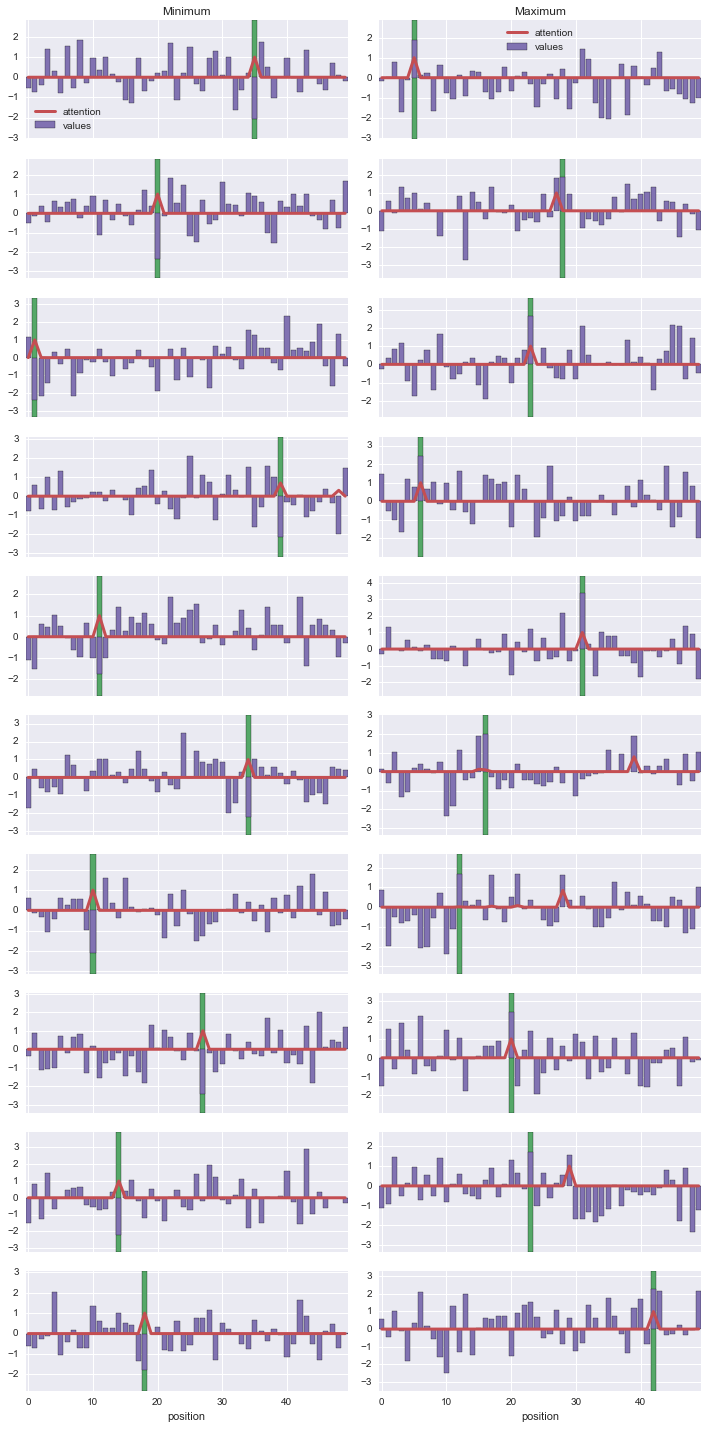

In [10]:
colors = sns.color_palette()
fig, axs = plt.subplots(len(min_data), 2, figsize=(10, 20), sharex=True)
axs_min, axs_max = axs[:,0], axs[:,1]

for i, ((min_values, min_probs, min_index), (max_values, max_probs, max_index)) in enumerate(zip(min_data, max_data)):
    
    min_lims = min(min_values) - 1, max(min_values) + 1
    axs_min[i].bar(np.arange(len(min_sort)) - 0.4, min_values, color=colors[3], zorder=2, label='values')
    axs_min[i].plot(min_probs, color=colors[2], lw=3, zorder=3, label='attention')
    axs_min[i].bar([min_index - 0.4], [min_lims[1] - min_lims[0]], bottom=[min_lims[0]], color=colors[1])
    axs_min[i].set_xlim(-0.4, len(min_sort) - 0.6)
    axs_min[i].set_ylim(min_lims)

    max_lims = min(max_values) - 1, max(max_values) + 1
    axs_max[i].bar(np.arange(len(max_sort)) - 0.4, max_values, color=colors[3], zorder=2, label='values')
    axs_max[i].plot(max_probs, color=colors[2], lw=3, zorder=3, label='attention')
    axs_max[i].bar([max_index - 0.4], [max_lims[1] - max_lims[0]], bottom=[max_lims[0]], color=colors[1])
    axs_max[i].set_xlim(-0.4, len(max_sort) - 0.6)
    axs_max[i].set_ylim(max_lims)

axs_min[0].set_title('Minimum')
axs_max[0].set_title('Maximum')
axs_max[0].legend(loc='best')    
axs_min[0].legend(loc='best')
axs_max[0].legend(loc='best')
axs_min[-1].set_xlabel('position')
axs_max[-1].set_xlabel('position')
plt.tight_layout()